In [1]:
from ipyparallel import Client
import os
c = Client(profile='mpi')
v = c[:]
c.ids

[0, 1, 2, 3, 4, 5, 6, 7]

# Libraries

In [2]:
%%px
%matplotlib inline

import os
import time
import numpy as np
import mpi4py.MPI as MPI

from matplotlib import cm
import matplotlib.pyplot as plt

import triangle

import pandas

from pyBadlands import FVmethod
from pyBadlands import raster2TIN 
from pyBadlands import flowNetwork
from pyBadlands import elevationTIN
from pyBadlands import partitionTIN

import warnings
warnings.filterwarnings("ignore")

# Initialise MPI communications
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

# Initialisation Phase

In [3]:
%%px
Init_time = time.clock()

## 1. Get DEM regular grid and create Badlands TIN.

In [4]:
#%%px
#if rank==0:
#    help(raster2TIN)

In [5]:
%%px
walltime = time.clock()

recGrid = raster2TIN.raster2TIN('/home/ubuntu/mpiPyLEM/data/regularMR.csv')

tinData = np.column_stack((recGrid.tinMesh['vertices'][:,0],
    recGrid.tinMesh['vertices'][:,1]))

if rank == 0:
    print " - read dataset and perform delaunay triangulation ", time.clock() - walltime

[stdout:7]  - read dataset and perform delaunay triangulation  1.276388


## 2. Partition the TIN

In [6]:
#%%px
#if rank==0:
#    help(partitionTIN.simple)

In [7]:
%%px
walltime = time.clock()

# Set parameters of the finite volume mesh
FVmesh = FVmethod.FVmethod(recGrid.tinMesh['vertices'],
                  recGrid.tinMesh['triangles'],
                  recGrid.tinMesh['edges'])

# Perform partitioning by equivalent domain splitting
RowProc = 4
ColProc = 2
partitionIDs = partitionTIN.simple(tinData[:,0], tinData[:,1], RowProc, ColProc)
FVmesh.partIDs = partitionIDs

# Get each partition global node ID
inGIDs = np.where(partitionIDs == rank)[0]

if rank == 0:
    print " - partition TIN amongst processors ", time.clock() - walltime

[stdout:7]  - partition TIN amongst processors  1.760554


## 3. Build Finite Volume discretisation

In [11]:
#%%px
#if rank==0:
#    help(FVmethod.FVmethod.construct_FV)

In [8]:
%%px

# Define overlapping partitions
allIDs, localTIN = partitionTIN.overlap(tinData[:,0], \
    tinData[:,1], RowProc, ColProc, 2*recGrid.resEdges)

# Set parameters of the finite volume mesh
tMesh = FVmethod.FVmethod(localTIN['vertices'],
                  localTIN['triangles'],
                  localTIN['edges'])

walltime = time.clock()

# Define Finite Volume parameters
totPts = len(tinData[:,0])
FVmesh.neighbours = np.zeros((totPts,20), dtype=np.int) 
FVmesh.neighbours.fill(-2)
FVmesh.edge_lenght = np.zeros((totPts,20), dtype=np.float) 
FVmesh.vor_edges = np.zeros((totPts,20), dtype=np.float) 
FVmesh.control_volumes = np.zeros(totPts, dtype=np.float) 

# Compute Finite Volume parameters
tGIDs, tNgbh, tEdgs, tVors, tVols = tMesh.construct_FV(inGIDs, allIDs, totPts)

FVmesh.neighbours[tGIDs,:tMesh.maxNgbh] = tNgbh
FVmesh.edge_lenght[tGIDs,:tMesh.maxNgbh] = tEdgs
FVmesh.vor_edges[tGIDs,:tMesh.maxNgbh] = tVors
FVmesh.control_volumes[tGIDs] = tVols

if rank == 0:
    print " - FV mesh ", time.clock() - walltime

[stdout:7] 
 - partition TIN including shadow zones  0.113297
 - build the voronoi diagram  0.08851
 - construct Finite Volume representation  0.191404
 - perform MPI communication  0.235395
 - FV mesh  0.950912


## 4. Interpolate elevation

In [15]:
#%%px
#if rank==0:
#    help(elevationTIN.update_border_elevation)

In [12]:
%%px
walltime = time.clock()
inIDs = np.where(FVmesh.partIDs[recGrid.boundsPt:] == rank)[0]
inIDs = inIDs + recGrid.boundsPt

local_elev = np.zeros(totPts)
local_elev.fill(-1.e6)
local_elev[inIDs] = elevationTIN.getElevation(recGrid.regX, recGrid.regY, \
    recGrid.regZ, FVmesh.node_coords[inIDs,:2])
comm.Allreduce(MPI.IN_PLACE, local_elev, op=MPI.MAX)

elevation = local_elev
elevation = elevationTIN.update_border_elevation(local_elev, \
    FVmesh.neighbours, FVmesh.edge_lenght, recGrid.boundsPt, btype='slope')

tinData = np.column_stack((tinData,elevation)) 
if rank == 0:
    print " - interpolate elevation on grid ", time.clock() - walltime

[stdout:7]  - interpolate elevation on grid  0.229942


In [16]:
%%px
if rank == 0:
    print " - Initialisation phase ", time.clock() - Init_time

[stdout:7]  - Initialisation phase  4.647198


# Flow computation

In [17]:
%%px
Flow_time = time.clock()

## 1. Perform pit filling

we still use the Planchon & Darboux algorithm but will try the Priority FLood algorithm from Barnes in a near future.

In [19]:
#%%px
#if rank==0:
#    help(elevationTIN.pit_filling_PD)

In [20]:
%%px
walltime = time.clock()
fillH = elevationTIN.pit_filling_PD(elevation, FVmesh.neighbours, \
                                    recGrid.boundsPt, 100. ,0.01)
if rank == 0:
    print " - depression-less algorithm PD with stack", time.clock() - walltime

[stdout:7]  - depression-less algorithm PD with stack 0.818309


## 2. Compute stream network

In [21]:
%%px
walltime = time.clock()
flow = flowNetwork()
ngbhs = FVmesh.neighbours[allIDs,:]
flow.SFD_receivers(fillH, ngbhs, allIDs)
if rank == 0:
    print " - compute receivers parallel ", time.clock() - walltime

# Distribute evenly local minimas to processors
walltime = time.clock()
flow.localbase = np.array_split(flow.base, size)[rank]
flow.ordered_node_array()
if rank == 0:
    print " - compute stack order locally ", time.clock() - walltime
    
walltime = time.clock()
stackNbs = comm.allgather(len(flow.localstack))
globalstack = np.zeros(sum(stackNbs),dtype=flow.localstack.dtype)
comm.Allgatherv(sendbuf=[flow.localstack, MPI.INT], 
             recvbuf=[globalstack, (stackNbs, None), MPI.INT]) 
flow.stack = globalstack
if rank == 0:
    print " - send stack order globally ", time.clock() - walltime

[stdout:7] 
 - compute receivers parallel  0.052948
 - compute stack order locally  0.043049
 - send stack order globally  0.009288


## 3. Compute discharge

In [22]:
%%px
walltime = time.clock()
rain = np.ones(totPts, dtype=float)
rain[:recGrid.boundsPt] = 0.
flow.compute_flow(FVmesh.control_volumes, rain)
if rank == 0:
    print " - compute discharge serial ", time.clock() - walltime

[stdout:7]  - compute discharge serial  0.059695


In [23]:
%%px
if rank == 0:
    print " - Flow computation ", time.clock() - Flow_time

[stdout:7]  - Flow computation  1.07953


# Save dataset to file

In [24]:
%%px
tinData = np.column_stack((tinData, flow.discharge))

In [25]:
%%px
walltime = time.clock()
outData = tinData[inIDs,:]
columns = ['X', 'Y', 'Z', 'FA']
index = np.arange(len(inIDs)) 

df = pandas.DataFrame(data=outData, columns=columns, index=index)

outfile = 'mpiPyLEM/output/output.'+str(rank)+'.csv'
df.to_csv(outfile, sep=',', encoding='utf-8')
if rank == 0:
    print " - write output ", time.clock() - walltime

[stdout:7]  - write output  0.597059


In [ ]:
!tar -cvf /home/ubuntu/mpiPyLEM/output/out.tar /home/ubuntu/mpiPyLEM/output/*.csv

# Plot the drainage

[output:7]

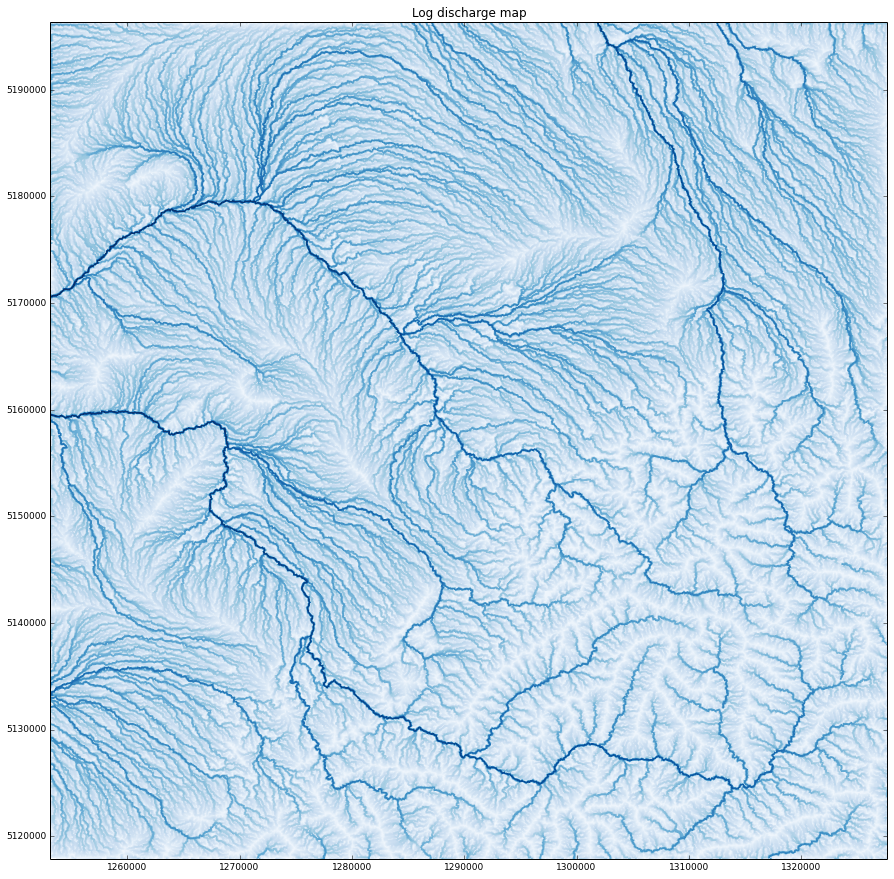

In [26]:
%%px
def plot_discharge(data,FA):
    colors = ['r', 'g', 'b', 'y', 'm', 'k', 'c', 'burlywood']
    fig = plt.figure(figsize = (15,15))
    plt.rc("font", size=9)
    
    #ax1 = fig.add_subplot(211,xlim=[data[:,0].min(), 
    #    data[:,0].max()], ylim=[data[:,1].min(), data[:,1].max()])
    #for i in range(size):
    #    ids = np.where(data[:,3] == i)[0]
    #    ax1.scatter(data[ids,0], data[ids,1], c=colors[i], 
    #        marker='o', alpha=0.5) 
    #ax1.set_title('Partition', fontsize=12)
    
    ax2 = fig.add_subplot(111,xlim=[data[:,0].min(), 
        data[:,0].max()], ylim=[data[:,1].min(), data[:,1].max()])
    ax2.tricontourf(data[:,0], data[:,1], np.log10(FA), 500, 
        cmap=plt.cm.Blues)
    ax2.set_title('Log discharge map', fontsize=12)
    plt.show()
    
wetIDs = np.where(flow.discharge > 0)[0]

if 0 == rank:
    plot_discharge(tinData[wetIDs,:],flow.discharge[wetIDs])